In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action="ignore")
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/autompg-dataset/auto-mpg.csv


In [270]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet , LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
from catboost import CatBoostRegressor

In [3]:
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.model_selection import train_test_split

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 170)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [14]:
data = pd.read_csv("/kaggle/input/autompg-dataset/auto-mpg.csv")
df = data.copy()
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.000,8,307.000,130,3504,12.000,70,1,chevrolet chevelle malibu
1,15.000,8,350.000,165,3693,11.500,70,1,buick skylark 320
2,18.000,8,318.000,150,3436,11.000,70,1,plymouth satellite
3,16.000,8,304.000,150,3433,12.000,70,1,amc rebel sst
4,17.000,8,302.000,140,3449,10.500,70,1,ford torino


In [157]:
def check_df(data):
    print("-------------------------------------------------- SHAPE --------------------------------------------------")
    print(data.shape)
    print("-------------------------------------------------- INFO --------------------------------------------------")
    print(data.info())
    print("-------------------------------------------------- ISNA --------------------------------------------------")
    print(data.isnull().sum().sort_values(ascending=False))
    print("-------------------------------------------------- NUNIQUE --------------------------------------------------")
    print(data.nunique())
    print("-------------------------------------------------- DESCRIBE --------------------------------------------------")
    print(data.describe().T)

In [158]:
check_df(df)

-------------------------------------------------- SHAPE --------------------------------------------------
(398, 9)
-------------------------------------------------- INFO --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   CYLINDERS     398 non-null    int64  
 2   DISPLACEMENT  398 non-null    float64
 3   HORSEPOWER    398 non-null    object 
 4   WEIGHT        398 non-null    int64  
 5   ACCELERATION  398 non-null    float64
 6   MODEL_YEAR    398 non-null    int64  
 7   ORIGIN        398 non-null    int64  
 8   CAR_NAME      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None
-------------------------------------------------- ISNA --------------------------------------------------
MPG             0
CYLIND

In [44]:
df.columns = df.columns.str.strip().str.replace(' ', '_')

In [47]:
df.columns = [col.upper() for col in df.columns]

In [48]:
df.head()

,MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODEL_YEAR,ORIGIN,CAR_NAME
0,18.000,8,307.000,130,3504,12.000,70,1,chevrolet chevelle malibu
1,15.000,8,350.000,165,3693,11.500,70,1,buick skylark 320
2,18.000,8,318.000,150,3436,11.000,70,1,plymouth satellite
3,16.000,8,304.000,150,3433,12.000,70,1,amc rebel sst
4,17.000,8,302.000,140,3449,10.500,70,1,ford torino


In [160]:
df.replace('?', np.NaN, inplace=True)

In [161]:
check_df(df)

-------------------------------------------------- SHAPE --------------------------------------------------
(398, 9)
-------------------------------------------------- INFO --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   CYLINDERS     398 non-null    int64  
 2   DISPLACEMENT  398 non-null    float64
 3   HORSEPOWER    392 non-null    object 
 4   WEIGHT        398 non-null    int64  
 5   ACCELERATION  398 non-null    float64
 6   MODEL_YEAR    398 non-null    int64  
 7   ORIGIN        398 non-null    int64  
 8   CAR_NAME      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB
None
-------------------------------------------------- ISNA --------------------------------------------------
HORSEPOWER      6
MPG   

In [166]:
def missing_values_table(data, na_name=False):
    na_columns = [col for col in data.columns if data[col].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    print(missing_df, end="\n")
    if na_name:
        return na_columns

In [167]:
na_columns = missing_values_table(df, na_name=True)

            n_miss  ratio
HORSEPOWER       6  1.510


In [168]:
df = df.dropna()

In [169]:
check_df(df)

-------------------------------------------------- SHAPE --------------------------------------------------
(392, 9)
-------------------------------------------------- INFO --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   CYLINDERS     392 non-null    int64  
 2   DISPLACEMENT  392 non-null    float64
 3   HORSEPOWER    392 non-null    object 
 4   WEIGHT        392 non-null    int64  
 5   ACCELERATION  392 non-null    float64
 6   MODEL_YEAR    392 non-null    int64  
 7   ORIGIN        392 non-null    int64  
 8   CAR_NAME      392 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 30.6+ KB
None
-------------------------------------------------- ISNA --------------------------------------------------
MPG             0
CYLINDERS  

In [170]:
def col_types(data,cat_th=25,num_th=10):
    cat_cols =[col for col in data.columns if data[col].dtypes=="o"]
    num_cols = [col for col in data.columns if data[col].dtypes!="o"]
    cat_but_num = [col for col in data.columns if data[col].dtypes=="o"
                  and data[col].nunique()>cat_th]
    num_but_cat = [col for col in data.columns if data[col].dtypes!="o"
                  and data[col].nunique()<num_th]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_num]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    
    print(f"Cat Cols : {len(cat_cols)}")
    print(f"Num Cols : {len(num_cols)}")
    print(f"Cat but Num Cols : {len(cat_but_num)}")
    print(f"Num but Cat Cols : {len(num_but_cat)}")
    
    return cat_cols , num_cols , cat_but_num

In [176]:
cat_cols , num_cols , cat_but_num = col_types(df)

Cat Cols : 2
Num Cols : 7
Cat but Num Cols : 0
Num but Cat Cols : 2


In [177]:
cat_cols

['CYLINDERS', 'ORIGIN']

In [178]:
num_cols

['MPG',
 'DISPLACEMENT',
 'HORSEPOWER',
 'WEIGHT',
 'ACCELERATION',
 'MODEL_YEAR',
 'CAR_NAME']

In [179]:
num_cols.remove("CAR_NAME")

In [180]:
num_cols

['MPG', 'DISPLACEMENT', 'HORSEPOWER', 'WEIGHT', 'ACCELERATION', 'MODEL_YEAR']

In [206]:
df["HORSEPOWER"] = df["HORSEPOWER"].astype(int)

In [181]:
def cat_plot(data,col_name):       
    sns.countplot(x=data[col_name],data=data)
    plt.title(col_name)
    plt.show()
    print(pd.DataFrame({col_name: data[col_name].value_counts(),
                        "Ratio": 100 * data[col_name].value_counts() / len(data)}))
    print("-----------------------------------------------------------------------------",end="\n\n\n")

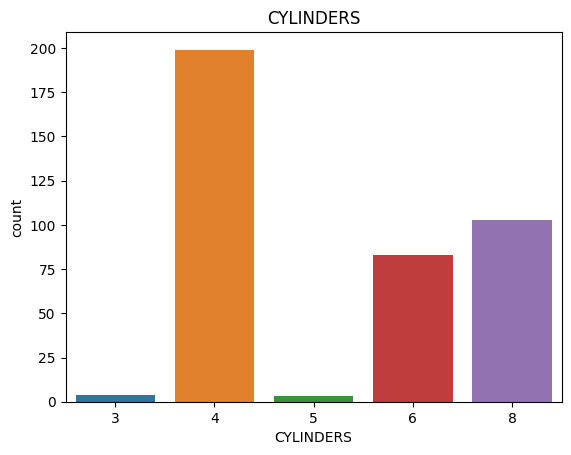

           CYLINDERS  Ratio
CYLINDERS                  
4                199 50.765
8                103 26.276
6                 83 21.173
3                  4  1.020
5                  3  0.765
-----------------------------------------------------------------------------




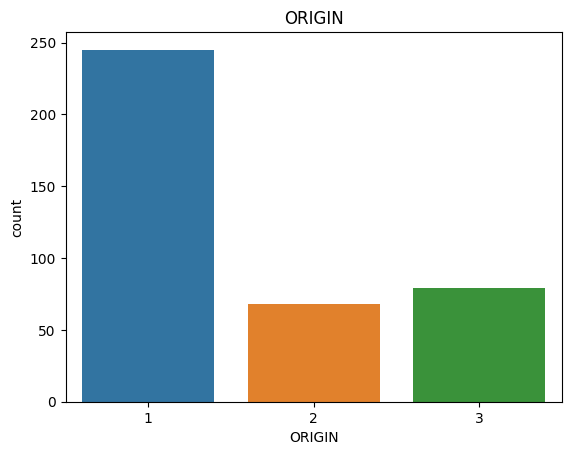

        ORIGIN  Ratio
ORIGIN               
1          245 62.500
3           79 20.153
2           68 17.347
-----------------------------------------------------------------------------




In [182]:
for col in cat_cols:
    cat_plot(df,col)

In [210]:
def num_plot(data,col_name):    
        colors = plt.cm.viridis(np.linspace(0,1,len(data[col_name].unique())))
        plt.hist(df[col_name],bins=50,color=colors[0],edgecolor='black',density=True)        
        sns.kdeplot(data[col_name], color='yellow', linewidth=2)
        plt.xlabel(col_name)
        plt.title(col_name)         
        plt.show()
        print(data[col_name].describe().T)  
        print("-----------------------------------------------------------------------------",end="\n\n\n")

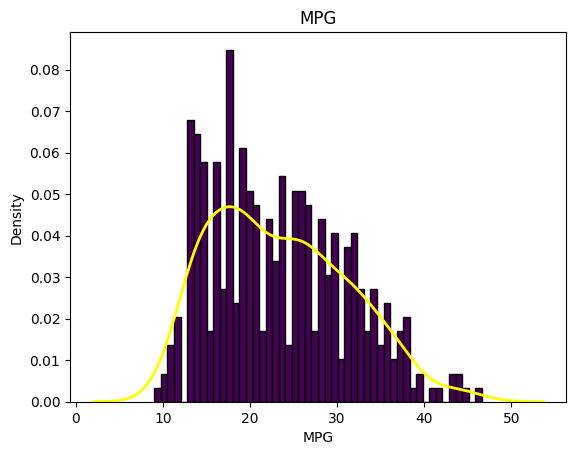

count   392.000
mean     23.446
std       7.805
min       9.000
25%      17.000
50%      22.750
75%      29.000
max      46.600
Name: MPG, dtype: float64
-----------------------------------------------------------------------------




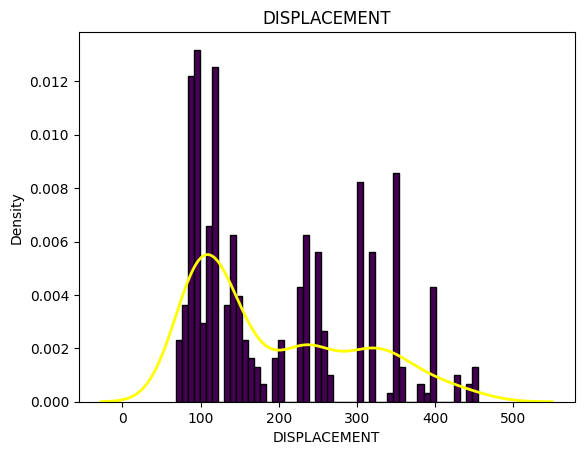

count   392.000
mean    194.412
std     104.644
min      68.000
25%     105.000
50%     151.000
75%     275.750
max     455.000
Name: DISPLACEMENT, dtype: float64
-----------------------------------------------------------------------------




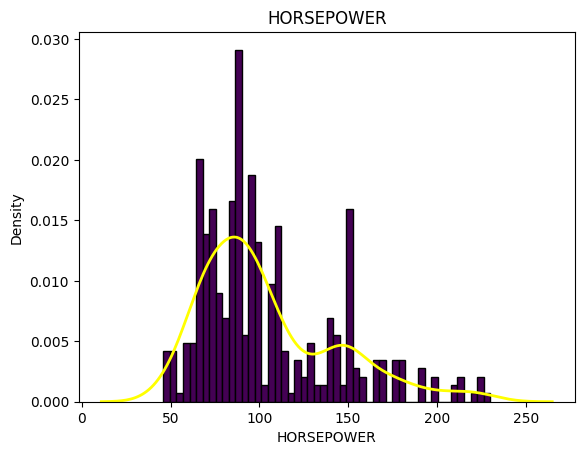

count   392.000
mean    104.469
std      38.491
min      46.000
25%      75.000
50%      93.500
75%     126.000
max     230.000
Name: HORSEPOWER, dtype: float64
-----------------------------------------------------------------------------




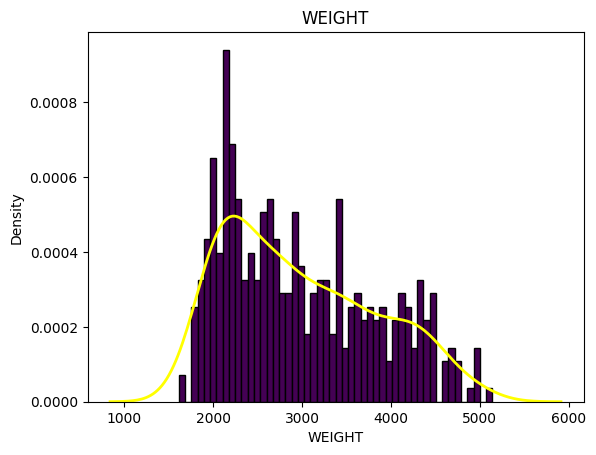

count    392.000
mean    2977.584
std      849.403
min     1613.000
25%     2225.250
50%     2803.500
75%     3614.750
max     5140.000
Name: WEIGHT, dtype: float64
-----------------------------------------------------------------------------




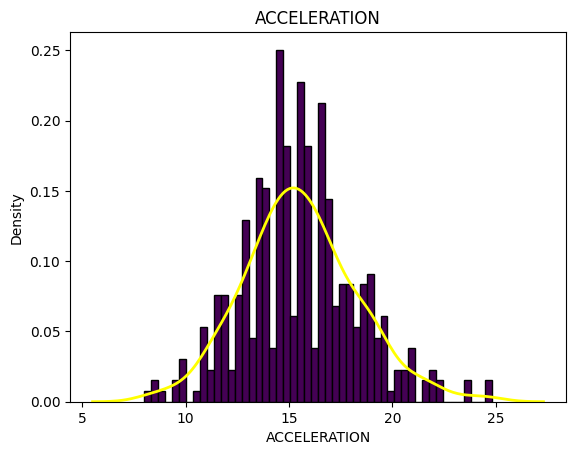

count   392.000
mean     15.541
std       2.759
min       8.000
25%      13.775
50%      15.500
75%      17.025
max      24.800
Name: ACCELERATION, dtype: float64
-----------------------------------------------------------------------------




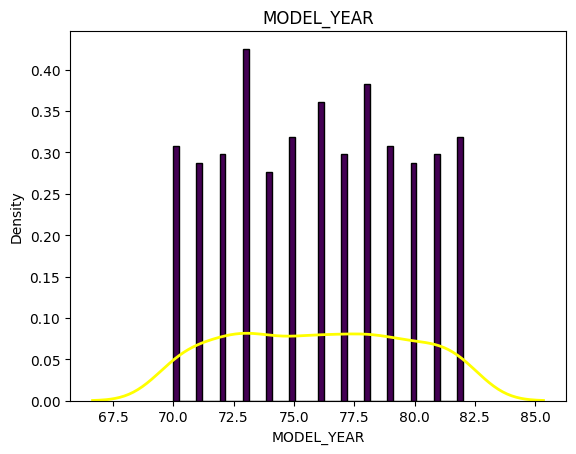

count   392.000
mean     75.980
std       3.684
min      70.000
25%      73.000
50%      76.000
75%      79.000
max      82.000
Name: MODEL_YEAR, dtype: float64
-----------------------------------------------------------------------------




In [211]:
for col in num_cols:
    num_plot(df,col)

In [185]:
def target_summary_cat(data,target,cat_col):
    print(cat_col)
    print(pd.DataFrame({target+"_MEAN":data.groupby(cat_col)[target].mean(),
                       "Count":data[cat_col].value_counts(),
                        "Ratio":100*data[cat_col].value_counts()/len(data)}),end="\n\n")

In [186]:
for col in cat_cols:
    target_summary_cat(df,"MPG",col)

CYLINDERS
           MPG_MEAN  Count  Ratio
CYLINDERS                        
3            20.550      4  1.020
4            29.284    199 50.765
5            27.367      3  0.765
6            19.973     83 21.173
8            14.963    103 26.276

ORIGIN
        MPG_MEAN  Count  Ratio
ORIGIN                        
1         20.033    245 62.500
2         27.603     68 17.347
3         30.451     79 20.153



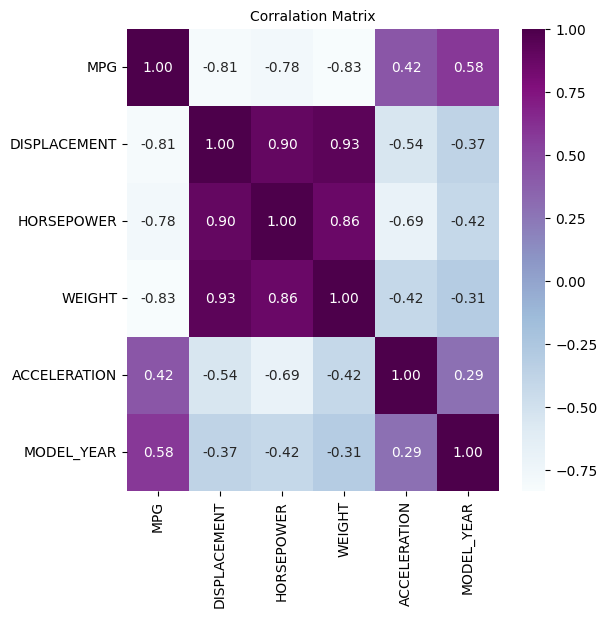

In [212]:
f,ax = plt.subplots(figsize=[6,6])
sns.heatmap(df[num_cols].corr(),annot=True,fmt=".2f",ax=ax,cmap="BuPu")
ax.set_title("Corralation Matrix",fontsize=10)
plt.show()

In [225]:
def outlier_thresholds(data,col_name,q1=0.15,q3=0.85):
  quantile1 = data[col_name].quantile(q1)
  quantile3 = data[col_name].quantile(q3)
  interquantile_range = quantile3 - quantile1
  up_limit = quantile3 + 1.5 * interquantile_range
  low_limit = quantile1 - 1.5 * interquantile_range
  return low_limit , up_limit

In [226]:
def check_outlier(data,col_name):
  low_limit,up_limit = outlier_thresholds(data,col_name)
  if data[(data[col_name]>up_limit)| (data[col_name]<low_limit)].any(axis=None):
    return True
  else:
    return False

In [227]:
def replace_with_thresholds(data,variable):
  low_limit,up_limit = outlier_thresholds(data,variable)
  dataframe.loc[(data[variable]<low_limit),variable] = low_limit
  dataframe.loc[(data[variable]>up_limit),variable] = up_limit

In [228]:
for col in num_cols:
    print(col,check_outlier(df,col))

MPG False
DISPLACEMENT False
HORSEPOWER False
WEIGHT False
ACCELERATION False
MODEL_YEAR False


In [235]:
df["NEW_WEIGHT_HP_RATIO"] = df["WEIGHT"] / df["HORSEPOWER"]

In [237]:
df["NEW_MILES_PER_HP"] = df["MPG"] / df["HORSEPOWER"]

In [241]:
df["NEW_WEIGHT_ACCEL_RATIO"] = df["WEIGHT"] / df["ACCELERATION"]

In [243]:
df["NEW_FUEL_EFFICIENCY_PERF"] = (df["MPG"] * df["ACCELERATION"])/ df["HORSEPOWER"]

In [244]:
df["NEW_HP_INCREASE"] = df["HORSEPOWER"] / df["MODEL_YEAR"]

In [245]:
df["NEW_CYLINDERS_WEIGHT_RATIO"] = df["CYLINDERS"] / df["WEIGHT"]

In [246]:
df["NEW_ENGINE_EFFICIENCY"] = df["DISPLACEMENT"] / df["CYLINDERS"]

In [247]:
df["NEW_FUEL_ECONOMY_SCORE"] = df["MPG"] * df["MODEL_YEAR"]

In [248]:
check_df(df)

-------------------------------------------------- SHAPE --------------------------------------------------
(392, 17)
-------------------------------------------------- INFO --------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   MPG                         392 non-null    float64
 1   CYLINDERS                   392 non-null    int64  
 2   DISPLACEMENT                392 non-null    float64
 3   HORSEPOWER                  392 non-null    int64  
 4   WEIGHT                      392 non-null    int64  
 5   ACCELERATION                392 non-null    float64
 6   MODEL_YEAR                  392 non-null    int64  
 7   ORIGIN                      392 non-null    int64  
 8   CAR_NAME                    392 non-null    object 
 9   NEW_WEIGHT_HP_RATIO         392 non-null   

In [249]:
df.head()

,MPG,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODEL_YEAR,ORIGIN,CAR_NAME,NEW_WEIGHT_HP_RATIO,NEW_MILES_PER_HP,NEW_WEIGHT_ACCEL_RATIO,NEW_FUEL_EFFICIENCY_PERF,NEW_HP_INCREASE,NEW_CYLINDERS_WEIGHT_RATIO,NEW_ENGINE_EFFICIENCY,NEW_FUEL_ECONOMY_SCORE
0,18.000,8,307.000,130,3504,12.000,70,1,chevrolet chevelle malibu,26.954,0.138,292.000,1.662,1.857,0.002,38.375,1260.000
1,15.000,8,350.000,165,3693,11.500,70,1,buick skylark 320,22.382,0.091,321.130,1.045,2.357,0.002,43.750,1050.000
2,18.000,8,318.000,150,3436,11.000,70,1,plymouth satellite,22.907,0.120,312.364,1.320,2.143,0.002,39.750,1260.000
3,16.000,8,304.000,150,3433,12.000,70,1,amc rebel sst,22.887,0.107,286.083,1.280,2.143,0.002,38.000,1120.000
4,17.000,8,302.000,140,3449,10.500,70,1,ford torino,24.636,0.121,328.476,1.275,2.000,0.002,37.750,1190.000


In [385]:
y = df[["MPG"]]
X = df.drop(["MPG","CAR_NAME"],axis=1)

In [325]:
X.head()

,CYLINDERS,DISPLACEMENT,HORSEPOWER,WEIGHT,ACCELERATION,MODEL_YEAR,ORIGIN,NEW_WEIGHT_HP_RATIO,NEW_MILES_PER_HP,NEW_WEIGHT_ACCEL_RATIO,NEW_FUEL_EFFICIENCY_PERF,NEW_HP_INCREASE,NEW_CYLINDERS_WEIGHT_RATIO,NEW_ENGINE_EFFICIENCY,NEW_FUEL_ECONOMY_SCORE
0,8,307.000,130,3504,12.000,70,1,26.954,0.138,292.000,1.662,1.857,0.002,38.375,1260.000
1,8,350.000,165,3693,11.500,70,1,22.382,0.091,321.130,1.045,2.357,0.002,43.750,1050.000
2,8,318.000,150,3436,11.000,70,1,22.907,0.120,312.364,1.320,2.143,0.002,39.750,1260.000
3,8,304.000,150,3433,12.000,70,1,22.887,0.107,286.083,1.280,2.143,0.002,38.000,1120.000
4,8,302.000,140,3449,10.500,70,1,24.636,0.121,328.476,1.275,2.000,0.002,37.750,1190.000


In [386]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.10,random_state=42)

In [387]:
print(f"X_train Shape : {X_train.shape}")
print(f"X_test Shape : {X_test.shape}")
print(f"y_train Shape : {y_train.shape}")
print(f"y_test Shape : {y_test.shape}")

X_train Shape : (352, 15)
X_test Shape : (40, 15)
y_train Shape : (352, 1)
y_test Shape : (40, 1)


In [328]:
from sklearn.preprocessing import MinMaxScaler

In [329]:
scaler = MinMaxScaler()

In [388]:
X_train = scaler.fit_transform(X_train)

In [390]:
X_test = scaler.fit_transform(X_test)

In [391]:
print(f"X_train Shape : {X_train.shape}")
print(f"X_test Shape : {X_test.shape}")
print(f"y_train Shape : {y_train.shape}")
print(f"y_test Shape : {y_test.shape}")

X_train Shape : (352, 15)
X_test Shape : (40, 15)
y_train Shape : (352, 1)
y_test Shape : (40, 1)


In [422]:
def base_models(X,y,scoring="r2"):
  print("Base Models")
  regressions = [('Ridge',Ridge(alpha=1)),
                 ('Lasso',Lasso(alpha=1)),
                 ('ElasticNet',ElasticNet(alpha=1,l1_ratio=0.5)),
                ("Linear",LinearRegression()),
                ("XGB",XGBRegressor(objective='reg:squarederror')),
                ("CatBoost",CatBoostRegressor(verbose=0))]
  for name,regression in regressions:
    cv_results = cross_validate(regression,X,y,cv=5,scoring=scoring)
    print(f"{scoring}: {round(cv_results['test_score'].mean(),4)} {name}")

In [395]:
base_models(X_train,y_train)

Base Models
r2: 0.9818 Ridge
r2: 0.5865 Lasso
r2: 0.4545 ElasticNet
r2: 0.9994 Linear
r2: 0.9924 XGB
r2: 0.9887 CatBoost


In [396]:
scoring_metrics = [
    "neg_mean_squared_error", 
    "neg_mean_absolute_error",
    "neg_root_mean_squared_error",              
    "explained_variance",       
    "max_error"]

In [397]:
for metric in scoring_metrics:
    print(f"\nResults for {metric}:")
    base_models(X, y, scoring=metric)


Results for neg_mean_squared_error:
Base Models
neg_mean_squared_error: -0.1527 Ridge
neg_mean_squared_error: -0.519 Lasso
neg_mean_squared_error: -0.2707 ElasticNet
neg_mean_squared_error: -0.0826 Linear
neg_mean_squared_error: -0.7966 XGB
neg_mean_squared_error: -1.2046 CatBoost

Results for neg_mean_absolute_error:
Base Models
neg_mean_absolute_error: -0.3057 Ridge
neg_mean_absolute_error: -0.5454 Lasso
neg_mean_absolute_error: -0.3816 ElasticNet
neg_mean_absolute_error: -0.2157 Linear
neg_mean_absolute_error: -0.6945 XGB
neg_mean_absolute_error: -0.7046 CatBoost

Results for neg_root_mean_squared_error:
Base Models
neg_root_mean_squared_error: -0.3633 Ridge
neg_root_mean_squared_error: -0.6459 Lasso
neg_root_mean_squared_error: -0.4659 ElasticNet
neg_root_mean_squared_error: -0.2628 Linear
neg_root_mean_squared_error: -0.8504 XGB
neg_root_mean_squared_error: -0.9973 CatBoost

Results for explained_variance:
Base Models
explained_variance: 0.9978 Ridge
explained_variance: 0.9945 La

In [423]:
def base_models_test(X_train, X_test, y_train, y_test, scoring="r2"):
    print("Base Models")
    regressions = [
        ('Ridge', Ridge(alpha=1)),
        ('Lasso', Lasso(alpha=1)),
        ('ElasticNet', ElasticNet(alpha=1, l1_ratio=0.5)),
        ('Linear', LinearRegression()),
        ('XGB', XGBRegressor(objective='reg:squarederror')),
        ('CatBoost', CatBoostRegressor(verbose=0))
    ]
    
    for name, regression in regressions:
        
        cv_results = cross_validate(regression, X_train, y_train, cv=5, scoring=scoring)
        mean_train_score = round(cv_results['test_score'].mean(), 4)
        
        
        regression.fit(X_train, y_train)
        y_pred = regression.predict(X_test)
        
        if scoring == "r2":
            test_score = r2_score(y_test, y_pred)
        elif scoring == "neg_mean_squared_error":
            test_score = mean_squared_error(y_test, y_pred)
        
        
        print(f"{scoring} (Train): {mean_train_score} - {name}")
        print(f"{scoring} (Test): {round(test_score, 4)} - {name}")

In [424]:
base_models_test(X_train,X_test,y_train,y_test)

Base Models
r2 (Train): 0.9818 - Ridge
r2 (Test): 0.9759 - Ridge
r2 (Train): 0.5865 - Lasso
r2 (Test): 0.6767 - Lasso
r2 (Train): 0.4545 - ElasticNet
r2 (Test): 0.5427 - ElasticNet
r2 (Train): 0.9994 - Linear
r2 (Test): 0.9823 - Linear
r2 (Train): 0.9924 - XGB
r2 (Test): 0.9862 - XGB
r2 (Train): 0.9887 - CatBoost
r2 (Test): 0.9945 - CatBoost


In [425]:
base_models_test(X_train,X_test,y_train,y_test,scoring="neg_mean_squared_error")

Base Models
neg_mean_squared_error (Train): -1.0884 - Ridge
neg_mean_squared_error (Test): 1.4337 - Ridge
neg_mean_squared_error (Train): -25.3149 - Lasso
neg_mean_squared_error (Test): 19.2384 - Lasso
neg_mean_squared_error (Train): -32.8489 - ElasticNet
neg_mean_squared_error (Test): 27.21 - ElasticNet
neg_mean_squared_error (Train): -0.0348 - Linear
neg_mean_squared_error (Test): 1.0544 - Linear
neg_mean_squared_error (Train): -0.4743 - XGB
neg_mean_squared_error (Test): 0.8228 - XGB
neg_mean_squared_error (Train): -0.725 - CatBoost
neg_mean_squared_error (Test): 0.326 - CatBoost


In [398]:
xgb_params = {
    'learning_rate': [None,0.01, 0.1],
    'n_estimators': [None,100, 200],
    'max_depth': [None,3, 5],
    'subsample': [None,0.8, 1.0]}

In [399]:
linear_params = {
    'fit_intercept': [True, False]
}

In [400]:
ridge_params = {
    'alpha': [0.1, 1.0, 10.0, 100.0],
    'solver': ['auto', 'sag','saga']}

In [401]:
catboost_params = {
    'iterations': [100, 500, 1000],             
    'depth': [4, 6, 8],                   
    'learning_rate': [0.01, 0.1]}

In [402]:
def hyperparameter_optimization(X, y, cv=5, scoring="r2"):
    print("HYPERPARAMETER OPTIMIZATION")
    best_models = {}
    
    regressors = [
        ('Ridge', Ridge(),ridge_params),
        ('CatBoost', CatBoostRegressor(verbose=0),catboost_params),
        ('Linear Regression', LinearRegression(), linear_params),
        ('XGBoost', XGBRegressor(objective='reg:squarederror'),xgb_params)
    ]

    for name, regressor, params in regressors:
        print(f"----------------- {name} -----------------")
        
        cv_results = cross_validate(regressor, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (Before): {round(cv_results['test_score'].mean(), 4)}")

        gs_best = GridSearchCV(regressor, params, cv=cv, n_jobs=-1, verbose=False).fit(X, y)

        final_model = regressor.set_params(**gs_best.best_params_)
       
        cv_results = cross_validate(final_model, X, y, cv=cv, scoring=scoring)
        print(f"{scoring} (After): {round(cv_results['test_score'].mean(), 4)}")
        print(f"{name} best params: {gs_best.best_params_}", end="\n\n")
        best_models[name] = final_model

    return best_models

In [403]:
best_models = hyperparameter_optimization(X_train,y_train)

HYPERPARAMETER OPTIMIZATION
----------------- Ridge -----------------
r2 (Before): 0.9818
r2 (After): 0.9976
Ridge best params: {'alpha': 0.1, 'solver': 'auto'}

----------------- CatBoost -----------------
r2 (Before): 0.9887
r2 (After): 0.9924
CatBoost best params: {'depth': 4, 'iterations': 1000, 'learning_rate': 0.1}

----------------- Linear Regression -----------------
r2 (Before): 0.9994
r2 (After): 0.9994
Linear Regression best params: {'fit_intercept': True}

----------------- XGBoost -----------------
r2 (Before): 0.9924
r2 (After): 0.9953
XGBoost best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}



In [404]:
from sklearn.ensemble import VotingRegressor
import joblib

In [405]:
best_models

{'Ridge': Ridge(alpha=0.1),
 'CatBoost': <catboost.core.CatBoostRegressor at 0x7de4483333d0>,
 'Linear Regression': LinearRegression(),
 'XGBoost': XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)}

In [406]:
def voting_regressor(best_models, X, y, cv=5):
    print("Voting Regressor")

    
    voting_reg = VotingRegressor(estimators=[
        ("XGB", best_models['XGBoost']),
        ("Ridge", best_models['Ridge']),
        ("Linear", best_models['Linear Regression']),
        ("CatBoost",best_models["CatBoost"])
    ]).fit(X, y)

   
    cv_results = cross_validate(voting_reg, X, y, cv=cv, scoring=["neg_mean_squared_error", "r2"])
    
    print(f"Neg MSE: {-cv_results['test_neg_mean_squared_error'].mean()}")  # Negatif MSE'yi pozitif yapmak için negatif işareti kaldırıyoruz
    print(f"R^2: {cv_results['test_r2'].mean()}")

    return voting_reg

In [407]:
voting_reg = voting_regressor(best_models,X_train,y_train)

Voting Regressor
Neg MSE: 0.12506498923621762
R^2: 0.9980064567010061


In [410]:
joblib.dump(voting_reg,"voting_reg1.pkl")

['voting_reg1.pkl']

In [411]:
predict_model = joblib.load("/kaggle/working/voting_reg1.pkl")

In [412]:
predict = predict_model.predict(X_test)

In [413]:
from sklearn.metrics import mean_squared_error, r2_score

In [414]:
print(f"R2 Score: {r2_score(y_test, predict):.4f}")
print(f"MSE: {mean_squared_error(y_test, predict):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, predict)):.4f}")

R2 Score: 0.9924
MSE: 0.4493
RMSE: 0.6703


In [430]:
def plot_importance_ensemble(voting_reg, features, num=len(X)):
    
    feature_imp_df = pd.DataFrame(0, index=features.columns, columns=["Value"])
    
    
    for model in voting_reg.estimators_:
        if hasattr(model, 'feature_importances_'):
            
            feature_imp_df["Value"] += model.feature_importances_ /100

    
    feature_imp_df["Feature"] = features.columns
    feature_imp_df = feature_imp_df.sort_values(by="Value", ascending=False)
    
    
    plt.figure(figsize=(12, 7))
    sns.set(font_scale=1)
    ax = sns.barplot(x="Value", y="Feature", data=feature_imp_df[0:num])
    
    for p in ax.patches:
        ax.annotate(format(p.get_width(), '.4f'),
                    (p.get_width(), p.get_y() + p.get_height() / 2),
                    ha='left', va='center', fontsize=8)
    
    plt.title("Feature Importance - Voting Regressor")
    plt.tight_layout()
    plt.show()

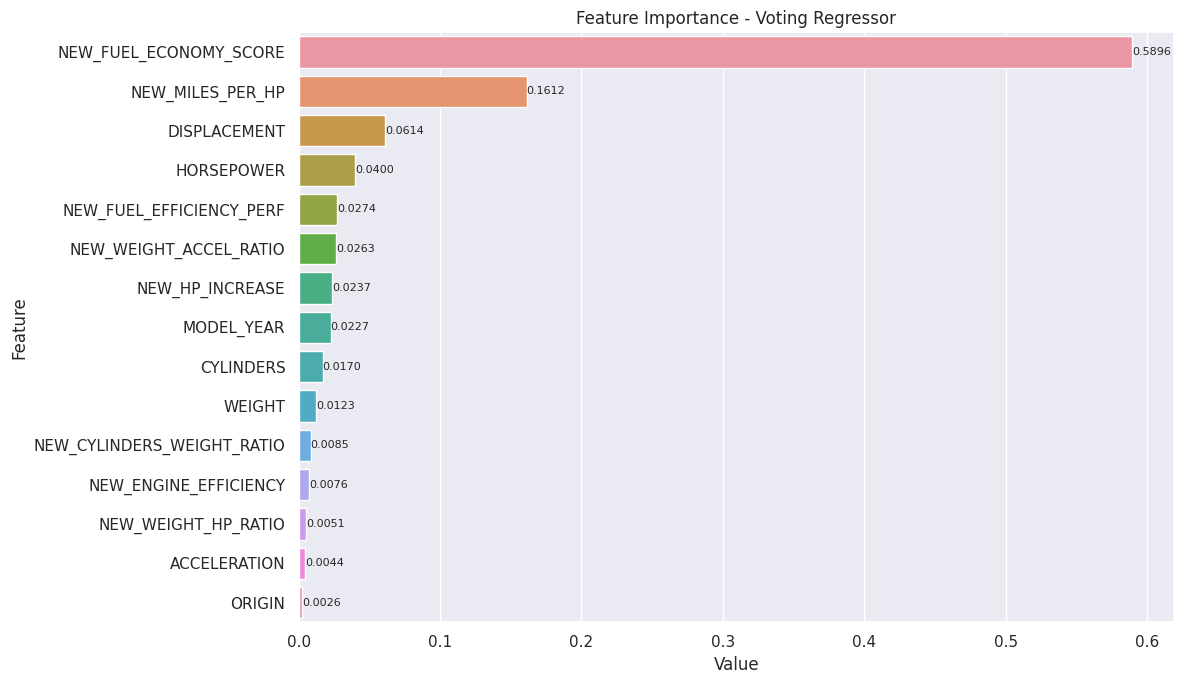

In [434]:
plot_importance_ensemble(predict_model, X)